<a href="https://colab.research.google.com/github/rjy1022/my_assets/blob/main/Sloppy_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import useful libraries
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
import numpy.linalg as linalg
import scipy.optimize as optimize
from scipy.optimize import least_squares

In [ ]:
#@title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

##The Fisher Information Matrix and Sloppy Models

As we've seen several times by now, when we're trying to infer the parameters ($\theta\in \mathcal{R}^p$) of a model, $\mathcal{M}$, based on data, $X$, we can calculate the *posterior distribution* of our parameter values given the the data via:
\begin{equation}
p(\theta \vert X) \propto p(X \vert \theta) p(\theta),
\end{equation}
where $p(X \vert \theta)$ is the *likelihood* of observing the data given a particular set of parameter values and $p(\theta)$ is our *prior* distribution over parameter space (we'll ignore the normalization from $p(X)$ for now).

As we saw in class, though, often the likelihood function often is not able to precisely specify one or many of the model's parameters.  We can quantify this notion using the Fisher Information Matrix (FIM) - which we will refer to as $g$.  In this matrix, each entry is the average curvature of the log-likelihood function in their respective parameter directions.  If we have a data set with $N$ data points, and $\theta_i$ and $\theta_j$ are two of the model parameters, then the FIM is given by:
\begin{equation}
g_{i,j} = -\sum_{k=1}^N p(x_k\vert\theta) \frac{\partial^2}{\partial\theta_i\partial\theta_j}\log p(x_k\vert\theta).
\end{equation}

Note how this matrix is symmetric ($\frac{\partial^2 f}{\partial x \partial y}=\frac{\partial^2 f}{\partial y \partial x}$) and real-valued, so it's a positive-definite matrix with (all eigenvales are greater than zero).  Thus, we can look at the eigenvalue structure.  

Here, large eigenvalues correspond to eigenvectors in parameter space that have a large curvature in the log-likelihood function - implying that we can perform inference well.  Small eigenvalues correspond to eigenvectors in parameter space that have small curvatures - implying that it will be very difficult to infer parameters along those directions.

In the case of least-squares fitting to a model function $f(t;\theta)$, we can define the FIM using:
\begin{equation}
g_{i,j} = \sum_{k=1}^N \frac{\partial f(t_k;\theta)}{\partial \theta_i}\frac{\partial f(t_k;\theta)}{\partial \theta_j} = (J^T(\theta) J(\theta))_{i,j},
\end{equation}
where $J(\theta)$ is the Jacobian matrix ($J_{k,i} = \frac{\partial f(t_k;\theta)}{\partial \theta_i}$).

##An Example: Mixtures of Exponentials

For this part of the exercise, you will try to infer the parameters from a model of the form:
\begin{equation}
y(t) = \sum_{i=1}^d A_i e^{-t/\tau_i}.
\end{equation}
The code below defines a function, ```multiExponential(t,As,taus)```, that generates outputs, ```y``` for input array ```t``` (and parameter arrays ```As``` and ```taus```), and ```createRandomExponentialModel(d)``` that will create a random model of order ```d``` (as defined in the equation above).

In [ ]:
def multiExponential(t,As,taus):
    y = np.zeros(len(t))
    L = len(As)
    for i in range(L):
        y += As[i]*np.exp(-t/taus[i])
    return y

def createRandomExponentialModel(d,Amax=10,tauMax = 10):
  As = random.uniform(0,Amax,d)
  taus = random.uniform(0,tauMax,d)
  return As,taus

<font color=blue>Question #1: Create a random exponential model with $d=7$ and plot its evaluation ($y$ vs. $t$) over ```np.arange(0,21,1)```.  Looking at this curve, would you expect to be able to infer all 14 parameters?  Why or why not?</font>

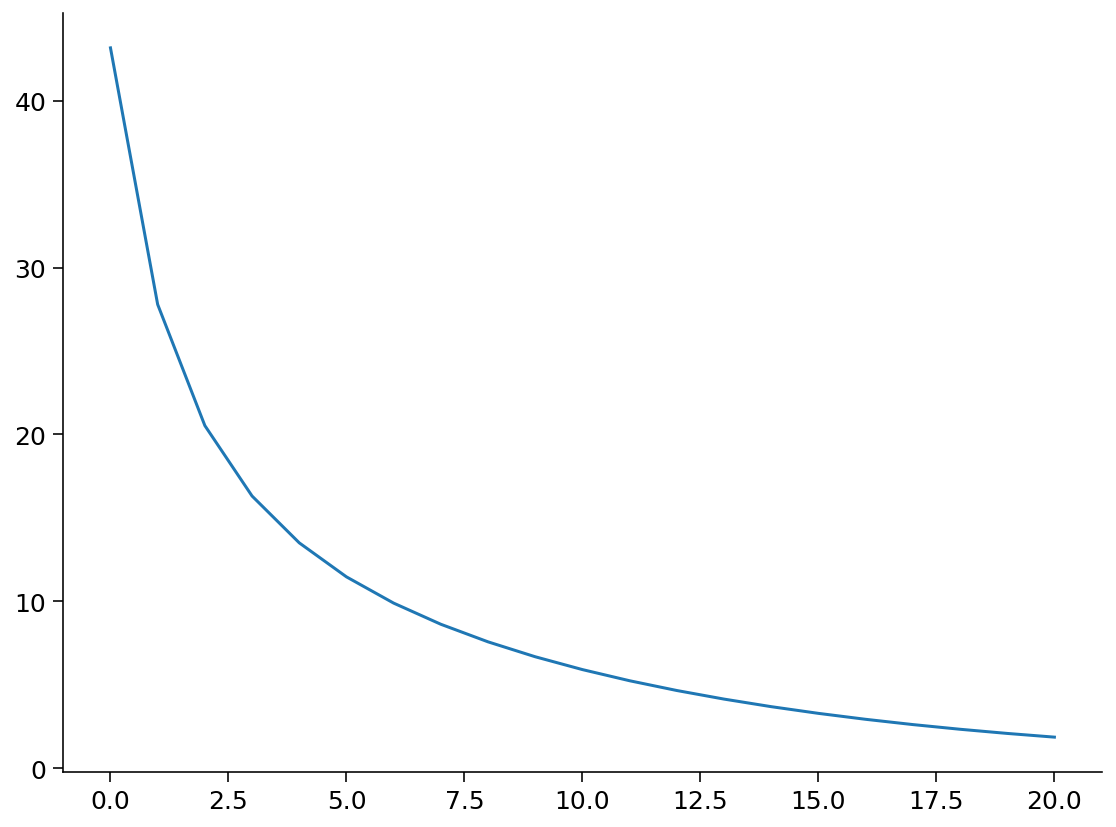

In [ ]:
#Type code for question #1 here.
As, taus = createRandomExponentialModel(7)
t = np.arange(0,21,1)

y = multiExponential(t, As, taus)
plt.plot(t, y)
plt.show()

<font color="green"> Looking at this curve, would you expect to be able to infer all 14 parameters?  Why or why not? 

No, because we don't have much data while we have lots of parameters.
</font>

The code below introduces a function, ```returnExponentialCurveFit(t,y,d)```, that fits a given data set (```t``` and ```y```) to the multi-exponential curve of order ```d``` above by minimizing the least squares function.  The output, ```yFit``` is the best-fit curve resulting from the fit.

In [ ]:
def leastSquaresFunction_Exponentials(theta,t,y):
  d = int(np.shape(theta)[0]/2)
  As = np.exp(theta[:d])
  taus = np.exp(theta[d:])
  return multiExponential(t,As,taus) - y

def returnExponentialCurveFit(t,y,d):

  A0 = np.log(random.dirichlet(np.ones(d))*y[0])
  tau0 = np.log(random.uniform(0,np.max(t),size=d))
  theta0 = np.zeros(2*d)
  theta0[:d] = A0
  theta0[d:] = tau0

  lsq = least_squares(leastSquaresFunction_Exponentials, theta0, args=(t, y))

  Afit = np.exp(lsq.x[:d])
  tauFit = np.exp(lsq.x[d:])

  yFit = multiExponential(t,Afit,tauFit)

  return yFit


<font color=blue> Question #2: Run ```returnExponentialCurveFit()``` for $d=1, 3, 5,$ and $7$ using your data from Question #1.  Plot the resulting best fit curves (comparing to the original data) for each fit.  Visually, which value of $d$ would you choose to model the data if you didn't know that it was actually generated from the $d=7$ equation?</font>

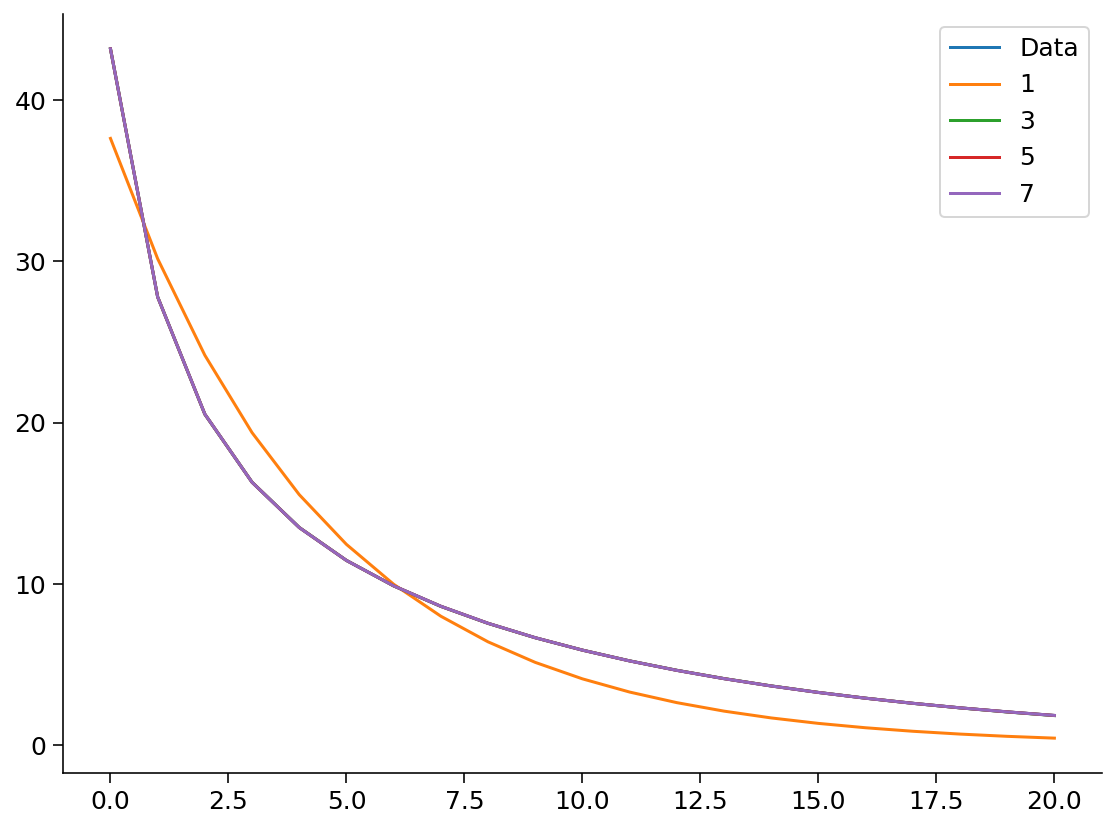

In [ ]:
#Type your code for Question #2 here
yFit1 = returnExponentialCurveFit(t, y, 1)
yFit3 = returnExponentialCurveFit(t, y, 3)
yFit5 = returnExponentialCurveFit(t, y, 5)
yFit7 = returnExponentialCurveFit(t, y, 7)

plt.plot(t, y)
plt.plot(t, yFit1)
plt.plot(t, yFit3)
plt.plot(t, yFit5)
plt.plot(t, yFit7)
plt.legend(["Data", "1", "3", "5", "7"])
plt.show()

<font color=green> Visually, which value of $d$ would you choose to model the data if you didn't know that it was actually generated from the $d=7$ equation? 

We would pick d=3 (yFit3) since it has the lowest complexity. </font>

As shown in class, for a least-squares fitting problem with uniform measurement error, $\sigma$, we can write the log-likelihood function via: 
\begin{equation}
\mathcal{L}(x\vert \theta) = -\frac{1}{2}\log\left(2\pi \sigma^2\right) - \frac{1}{2\sigma^2}\chi^2(\theta,y),
\end{equation}
where
\begin{equation}
\chi^2(\theta,y) = \sum_{k=1}^N \left[y_i - \hat{y}(x_i,\theta) \right]^2
\end{equation}
and $\hat{y}(x_i,\theta)$ is the best-fit curve.

<font color=blue> Question #3: Add gaussian noise with standard deviation $\sigma = .1$ to your previous value of ```y``` to make a new variable, ```z```.  Rembering that the BIC = $-2\mathcal{L}(x\vert \theta,\mathcal{M}) + p\log N$, use Bayesian model selection to select the most likely value for $d$ given the data.  Explain your reasoning. (You can assume that $\sigma$ in the log-likelihood equation above is equal to .1)</font>

In [ ]:
#Type code for Question #3 here
z = y + np.random.normal(0, 0.1, len(y))

def bic(sd, z, y, p):
  ls = np.sum((z - y) ** 2)
  loglik = (-1/2) * np.log(2 * np.pi * sd) - (1 / (2 * sd)) * ls
  bic = -2 * loglik + p * np.log(len(z))
  return bic

bic1 = bic(.1, z, yFit1, 1)
bic3 = bic(.1, z, yFit3, 3)
bic5 = bic(.1, z, yFit5, 5)
bic7 = bic(.1, z, yFit7, 7)

print("Bic 1: {}".format(bic1))
print("Bic 3: {}".format(bic3))
print("Bic 5: {}".format(bic5))
print("Bic 7: {}".format(bic7))


Bic 1: 1020.3660841438306
Bic 3: 10.14492627110516
Bic 5: 16.150812279316707
Bic 7: 22.239838107952565


<font color = green> Explain your reasoning. 

We would pick parameter = 3, since it has the lowest BIC. This is because it fits the curve about as well as parameter = 7 and it does so at a lower complexity, therefore, BIC prefers it.</font>

### The Fisher Information Matrix

For the multi-exponential system, our partial derivatives are given by:
\begin{eqnarray}
\frac{\partial y(t;\theta)}{\partial A_i} &=& e^{-t/\tau_i} \\
\frac{\partial y(t;\theta)}{\partial \tau_i } &=& \frac{A_i t}{\tau_i^2}e^{-t/\tau_i}.
\end{eqnarray}

<font color=blue>Question #4: Write a function ```returnFisherInformationMultiExponentials(t,y,As,taus)``` that returns the Fisher Information Matrix for the multi-exponential model near the "true" value of the model ($d=7$).  Note that the output should be a $2d\times 2d$ matrix.  </font>

In [ ]:
#Type code for Question #4 here
def returnFisherInformationMultiExponentials(t,y,As,taus):
  L = np.shape(As)[0]
  jacob = np.zeros((len(t), 2*L))

  for x in range(7):
    pd1 = np.exp(-t / taus[x]) # 50 x 1
    for i in range(len(t)):
      jacob[i,x] = pd1[i] # 
  
  for x in range(7, 14):
    pd2 = (As[x-7] * t) / (taus[x-7] ** 2) * jacob[i, x-7]
    for i in range(len(t)): 
      jacob[i,x] = pd2[i]
    
  return np.dot(jacob.T, jacob)

In [ ]:
def makeEigPlot(vals):
    np.sort(vals)[::-1]
    L = np.shape(vals)[0]
    for i in range(L):
        plt.semilogy([0,1],[vals[i],vals[i]],'k-')
    plt.xlim([-.1, 1.1])
    plt.ylabel('Eigenvalues')
    plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 
    plt.show()

<font color=blue> Question #5: Calculate the eigenvalues and eigenvectors for the FIM using ```t```, ```As``` and ```taus``` from Question #1 and ```z``` from question #2 as your value for $y$.  Use ```makeEigPlot(eigenvalues)``` (in the cell above) to plot the eigenvalue spectrum for your FIM.  Does this model appear to be sloppy?  Is it identifiable?

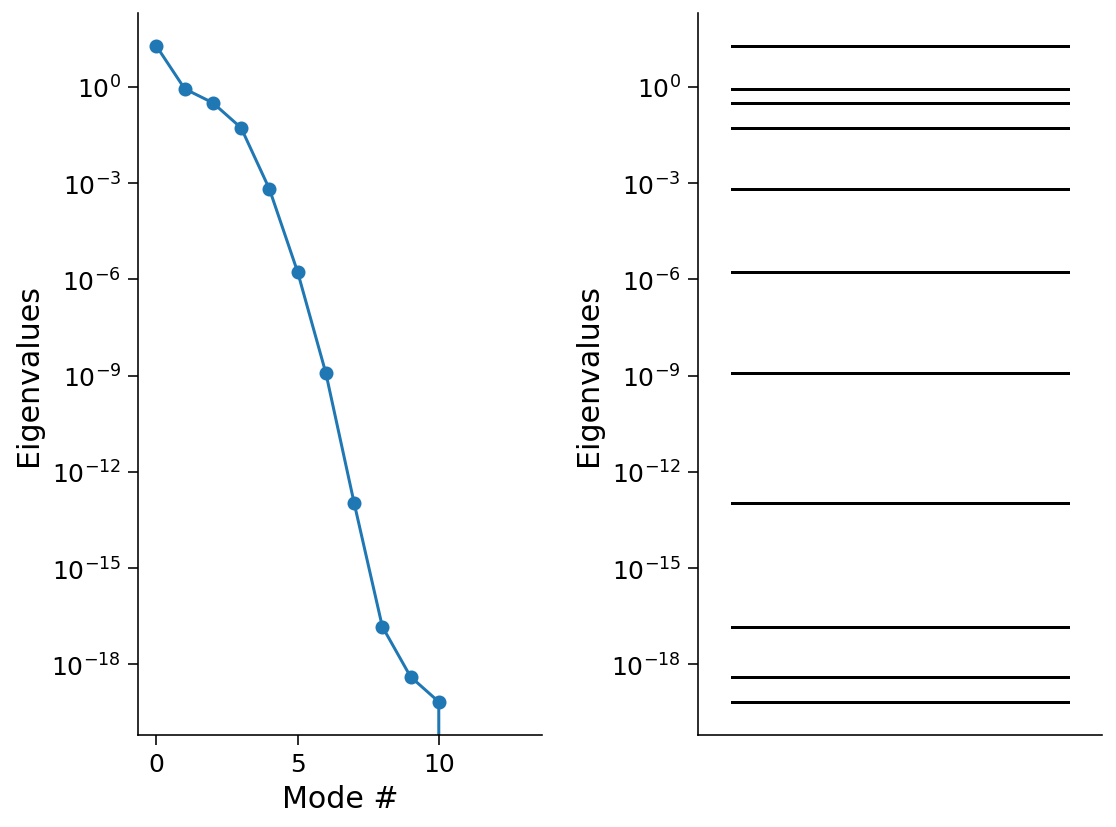

In [ ]:










#Enter your code for Question #5 here
fim = returnFisherInformationMultiExponentials(t,z,As,taus)
eigvals, eigvecs = linalg.eig(fim)

plt.subplot(1,2,1)
plt.semilogy(np.sort(vals)[::-1],'o-')
plt.ylabel('Eigenvalues')
plt.xlabel('Mode #')
plt.subplot(1,2,2)
makeEigPlot(vals)

<font color="green"> Does this model appear to be sloppy?  Is it identifiable? 

It does appear to be sloppy and unidentifiable.</font>

<font color=blue> Question #6: Visualize the eigenvectors from Question #5 using the method of your choosing.  Would it be easy to eliminate the smallest eigenvectors from your model?  Explain your reasoning.

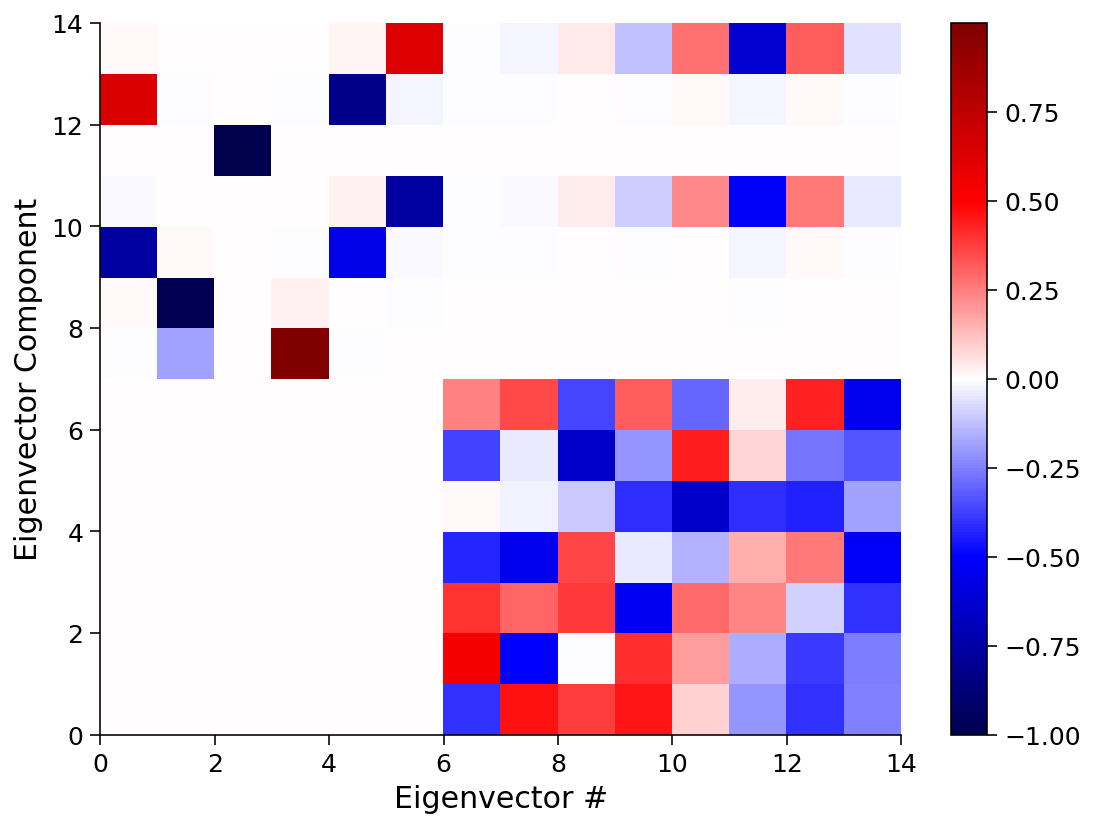

In [ ]:













#Enter your code for Question #6 here

#sort the eigenvalues & eigenvectors
eigvals_sorted = np.sort(eigvals)
eigvecs_sorted = eigvecs[:, eigvals.argsort()]

#plot
plt.pcolor(eigvecs_sorted)
plt.colorbar()
plt.set_cmap('seismic')
plt.xlabel('Eigenvector #')
plt.ylabel('Eigenvector Component')
plt.show()

<font color=green> Would it be easy to eliminate the smallest eigenvectors from your model?  Explain your reasoning. 

Our current model has an order of 7 (d=7) and has 14 parameters. With a high number of parameters, complexity increases, so it would not be easy to eliminate the smallest eigenvectors from our model.
</font>